# AICE Professioanl 대비 - 이미지 처리(CNN, Transfer-Learning) 실습
- 고양이 vs 개 (Cats vs Dogs) 데이터셋:
이 데이터셋은 이진 분류를 위한 대표적인 이미지 데이터셋으로, TensorFlow Datasets에서 Load 가능

## 모델링 순서

**1. 데이터 로드 및 공통 전처리**
- train_data, validation_data Load
- 데이터 시각화
- Preprocess -> /.255(정규화)

**2. 기본 CNN 모델**
- 2.1 CNN 모델링
- 2.2 CNN 모델 평가 및 예측
- 2.3 CNN 모델 예측결과 시각화

**3. Transfer Learninig-VGG**
- 3.1 VGG16 모델링
- 3.2 VGG16 모델 평가 및 예측
- 3.3 VGG16 모델 예측결과 시각화

**4. Transfer Learninig-MobileNET**
- 4.1 MobileNetV2 모델링
- 4.2 MobileNetV2 모델 평가 및 예측
- 4.3 MobileNetV2 모델 예측결과 시각화

**5. Tensorflow - image_dataset_from_directory, ImageDataGenerator 활용 모델링**
- 5.1 image_dataset_from_directory Data Load
- 5.2 기본CNN, MobileNetV2 모델링/평가/예측/시각화
- 5.3 image data generator 활용 Data Augmentation
- 5.4 Augmented Dataset 기반 기본CNN 모델 성능개선 평가





---



---



# 1. 데이터 로딩 및 전처리

- tensorflow_datasets: 다양한 데이터셋을 손쉽게 불러올 수 있는 라이브러리입니다.
- split: 데이터셋을 훈련 및 검증 세트로 분할합니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# 데이터셋 로드
import tensorflow_datasets as tfds

(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.IDE7FJ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# 이미지 크기 및 배치 사이즈 설정
IMG_SIZE = 224 ##향후 실습에서 VGG, MobileNet Pre-trained Model은 224,224 input size
BATCH_SIZE = 64

# 전처리 함수 정의
def format_example(image, label):
"""
함수를 입력하세요
"""

# 데이터셋 전처리 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)


In [ ]:
get_label_name = lambda label: 'Cats' if label == 0 else 'Dogs'
print(get_label_name)

<function <lambda> at 0x7b2eb940ab90>


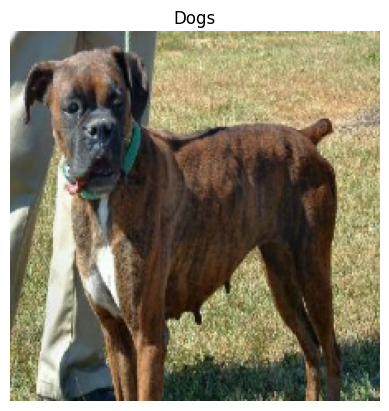

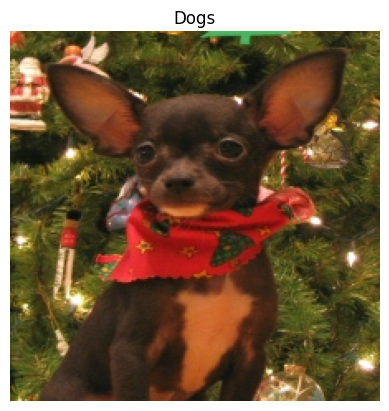

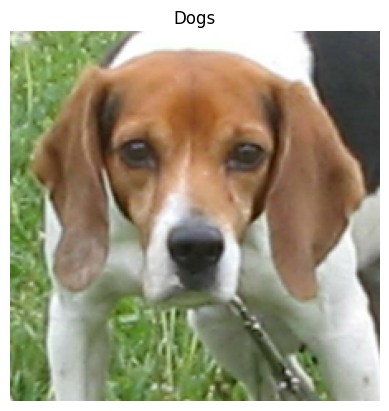

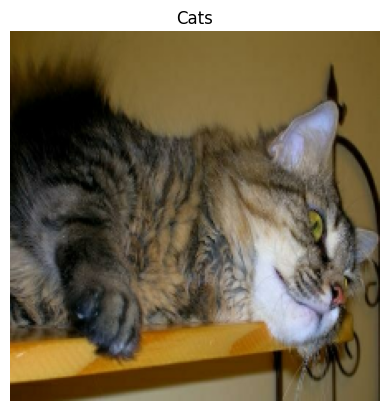

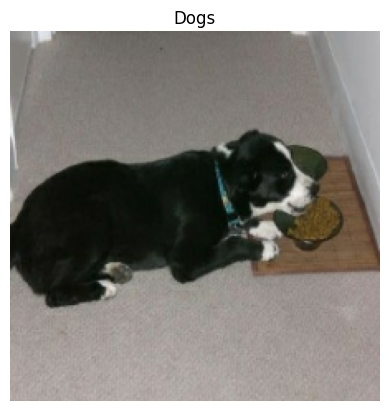

In [ ]:
# 일부 이미지를 시각화
import matplotlib.pyplot as plt

# 훈련 데이터에서 처음 5개의 이미지와 레이블을 가져옵니다.
for image, label in train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
    plt.show()

# 배치 적용
train = train.batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)




---



---



# 2. 기본 CNN 모델

- Convolutional Layers: 이미지에서 특징을 추출하는 층입니다. 커널(필터)을 사용하여 이미지의 작은 부분을 스캔하고, 이를 통해 특징 맵(feature map)을 생성합니다.
- Pooling Layers: 주로 MaxPooling을 사용하여, 특징 맵에서 중요한 정보를 추출하면서 차원을 줄입니다. 이를 통해 계산 비용을 줄이고, 모델이 과적합되는 것을 방지할 수 있습니다.
- Flatten Layer: 2D 형태의 특징 맵을 1D 벡터로 변환하여 Fully Connected Layer에 전달합니다.
- Fully Connected Layer: 모든 뉴런이 연결된 층으로, 학습된 특징을 바탕으로 최종 분류를 수행합니다.
- Activation Function (ReLU): 비선형성을 추가하여 모델이 복잡한 패턴을 학습할 수 있도록 도와줍니다.
- Sigmoid Activation: 최종 출력층에서 이진 분류를 위해 사용됩니다. 출력을 0과 1 사이의 값으로 제한하여, 고양이 또는 강아지로 분류합니다.

1) Conv2D 레이어

layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))

 역할: 이미지에서 특징을 추출하는 역할을 하며, 필터를 사용해 입력 이미지에 대해 컨볼루션 연산을 수행합니다.
 파라미터 설명:
- 32: 이 레이어에서 사용하는 **필터(filter)**의 개수. 즉, 출력으로 32개의 특징 맵(feature map)을 만듭니다.
- (3, 3): 필터의 크기를 의미합니다. 3x3 크기의 필터를 사용해 이미지를 스캔합니다.
- activation='relu': 활성화 함수로 ReLU(Rectified Linear Unit)를 사용하여 비선형성을 추가합니다.
- input_shape=(224, 224, 3): 이미지의 크기가 224x224 픽셀이고, 3개의 채널(RGB)을 가집니다.


---


2) MaxPooling2D 레이어:

layers.MaxPooling2D((2, 2))

역할: 특징 맵의 크기를 줄여서 계산 비용을 줄이고, 중요한 특징만 남기기 위해 최대 풀링을 사용합니다.
(2, 2): 2x2의 풀링 창을 사용해 특징 맵의 크기를 절반으로 줄입니다.


---


3) Flatten 레이어:

layers.Flatten()

역할: Conv2D 레이어에서 나온 2D 형태의 특징 맵을 1D 벡터로 변환하여 전결합(Dense) 레이어에 전달할 준비를 합니다.





In [ ]:
# 기본 CNN 모델 정의
cnn_model = tf.keras.models.Sequential([
  """모델 구조 코드를 작성하시오"""
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 모델 컴파일
cnn_model.compile(optimizer='adam',
                  loss='빈칸입력하시오.',
                  metrics=[빈칸입력하시오.])
# 모델 요약 정보 출력
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = 빈칸입력하시오(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = 빈칸입력하시오(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# 모델 학습
history_cnn = cnn_model.fit(train, validation_data=validation, epochs=10, batch_size=BATCH_SIZE, callbacks=빈칸입력하시오, verbose=1)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5460 - loss: 0.7000
Epoch 1: val_loss improved from inf to 0.58481, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - accuracy: 0.5461 - loss: 0.6999 - val_accuracy: 0.6890 - val_loss: 0.5848
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7112 - loss: 0.5582
Epoch 2: val_loss improved from 0.58481 to 0.48718, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 51s 174ms/step - accuracy: 0.7113 - loss: 0.5581 - val_accuracy: 0.7724 - val_loss: 0.4872
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7892 - loss: 0.4534
Epoch 3: val_loss improved from 0.48718 to 0.41885, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.7892 - loss: 0.4533 - val_accuracy: 0.8147 - val_loss: 0.4189
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8270 - loss: 0.3914
Epoch 4: val_loss improve

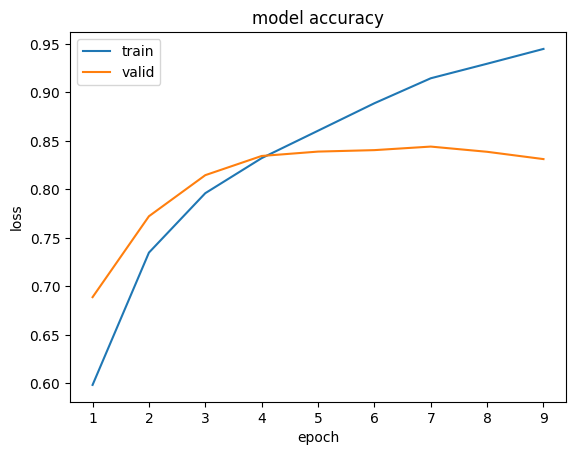

In [ ]:
##학습히스토리를 그래프로 그리시오.
epochs = range(1, len(history_cnn.history['accuracy']) + 1)
plt.plot(epochs, history_cnn.history['accuracy'])
plt.plot(epochs, history_cnn.history['val_accuracy'])


## 모델 평가 및 예측, 시각화

In [ ]:
# 모델 평가
loss, accuracy = cnn_model.evaluate(validation)
print(f'기본 CNN 모델 정확도: {accuracy}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8334 - loss: 0.6609
기본 CNN 모델 정확도: 0.8312553763389587


In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = cnn_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()




---



---



# 3.Transfer Learninig-VGG
## 3.1 VGG16 모델링
**VGG16을 사용한 Transfer Learning 모델링**
- VGG16은 이미지 분류에서 성능이 우수한 사전 훈련된 모델입니다. Transfer Learning은 미리 학습된 모델을 가져와 새로운 작업에 맞게 미세 조정(fine-tuning)하는 방식입니다. 이는 데이터가 많지 않거나 학습 시간이 부족할 때 매우 유용합니다.

In [ ]:
# VGG16 모델 불러오기 (사전 훈련된 가중치 사용)
vgg16_base = """입력하세요"""

# 사전 학습된 층을 고정
vgg16_base.trainable = False

# VGG16을 이용한 모델 구축
vgg16_model = models.Sequential([
    """입력하세요""",
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# 모델 컴파일
vgg16_model.compile(optimizer='adam',
                    loss='"""입력하세요"""',
                    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# 모델 학습
history_vgg16 = vgg16_model.fit(
    train,
    validation_data=validation,
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[es, cp],
    verbose=1
)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8295 - loss: 0.8369
Epoch 1: val_loss improved from inf to 0.22387, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 137s 398ms/step - accuracy: 0.8298 - loss: 0.8352 - val_accuracy: 0.9043 - val_loss: 0.2239
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9404 - loss: 0.1513
Epoch 2: val_loss improved from 0.22387 to 0.16846, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 93s 297ms/step - accuracy: 0.9404 - loss: 0.1513 - val_accuracy: 0.9314 - val_loss: 0.1685
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9432 - loss: 0.1335
Epoch 3: val_loss did not improve from 0.16846
291/291 ━━━━━━━━━━━━━━━━━━━━ 89s 304ms/step - accuracy: 0.9433 - loss: 0.1334 - val_accuracy: 0.8742 - val_loss: 0.3763
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9529 - loss: 0.1103
Epoch 4: val_loss did not improve from 0.16846
291/291 ━━━━━━━━━━━

## 3.2 VGG16 모델 평가 및 예측

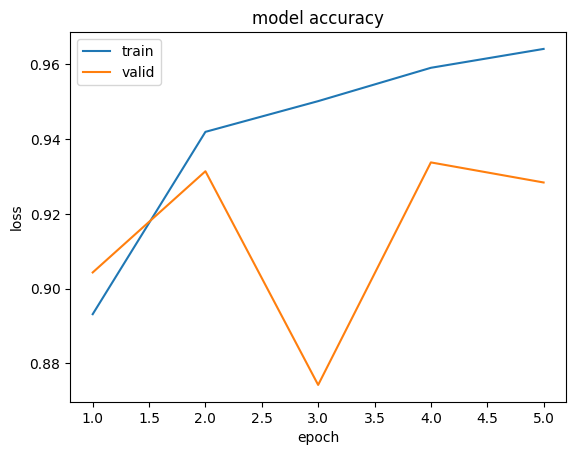

In [ ]:
epochs = range(1, len(history_vgg16.history['accuracy']) + 1)
plt.plot(epochs, history_vgg16.history['accuracy'])
plt.plot(epochs, history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], )
plt.show()

In [ ]:
# 모델 평가
loss, accuracy = vgg16_model.evaluate(validation)
print(f'VGG16 모델 정확도: {accuracy}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9317 - loss: 0.1775
기본 CNN 모델 정확도: 0.9284178614616394


## 3.3 VGG16 모델 예측결과 시각화

In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = vgg16_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()




---



---



# 4. Transfer Learninig-MobileNET
## 4.1 MobileNetV2 모델링
**MobileNet을 사용한 Transfer Learning**
- MobileNet은 경량화된 모델로, 특히 모바일 및 임베디드 장치에서 효율적으로 사용할 수 있습니다. VGG16보다 더 적은 계산 비용으로 높은 성능을 발휘하는 것이 특징입니다.

In [ ]:
# MobileNetV2 모델 불러오기 (사전 훈련된 가중치 사용)
mobilenet_base = tf.keras.applications."""입력하세요"""(input_shape=("""입력하세요""", """입력하세요""", 3),
                                                   include_top=False,
                                                   weights='imagenet')

# 사전 학습된 층을 고정
mobilenet_base.trainable = False

# MobileNet을 이용한 모델 구축
mobilenet_model = models.Sequential([
    """입력하세요""",
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# 모델 컴파일
mobilenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)


In [ ]:
# 모델 학습
history_mobilenetV2 = mobilenet_model.fit(
    train,
    validation_data=validation,
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[es, cp],
    verbose=1
)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9462 - loss: 0.1543
Epoch 1: val_loss improved from inf to 0.04684, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 69s 188ms/step - accuracy: 0.9463 - loss: 0.1541 - val_accuracy: 0.9834 - val_loss: 0.0468
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9836 - loss: 0.0480
Epoch 2: val_loss improved from 0.04684 to 0.04183, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 59s 133ms/step - accuracy: 0.9836 - loss: 0.0480 - val_accuracy: 0.9841 - val_loss: 0.0418
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9855 - loss: 0.0419
Epoch 3: val_loss improved from 0.04183 to 0.04044, saving model to tmp_checkpoint.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9855 - loss: 0.0419 - val_accuracy: 0.9845 - val_loss: 0.0404
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9869 - loss: 0.0385
Epoch 4: val_loss improve

## 4.2 MobileNetV2 모델 평가 및 예측

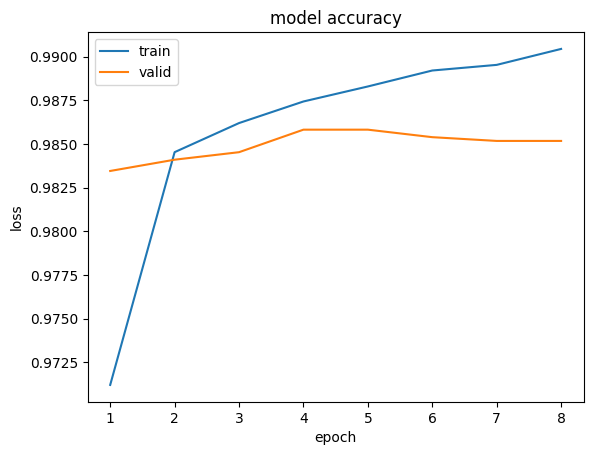

In [ ]:
epochs = range(1, len(history_mobilenetV2.history['accuracy']) + 1)
plt.plot(epochs, history_mobilenetV2.history['accuracy'])
plt.plot(epochs, history_mobilenetV2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], )
plt.show()

In [ ]:
# 모델 평가
loss, accuracy = mobilenet_model.evaluate(validation)
print(f'MobileNetV2 모델 정확도: {accuracy}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9860 - loss: 0.0372
기본 CNN 모델 정확도: 0.9851676821708679


## 4.3 MobileNetV2 모델 예측결과 시각화

In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = mobilenet_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()





---



---



# 5. Tensorflow - image_dataset_from_directory, ImageDataGenerator 활용 모델링
# **AICE Professional_이미지실습_CNN,TransferLearning(Cats vs Dogs)_image_dataset_from_directory,IDG_정병혁.ipynb 노트북 실습파일 사용
https://colab.research.google.com/drive/1_JkU__MxRmEiZO4BcxSnl8fsnR8gWk43#scrollTo=_88a8fsd2Usw

# 5. Tensorflow - image_dataset_from_directory, ImageDataGenerator 활용 모델링
## 5.1 image_dataset_from_directory Data Load


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil

In [ ]:
# 이미지 크기 및 배치 사이즈 설정
IMG_SIZE = 224  # 향후 실습에서 VGG, MobileNet Pre-trained Model은 224,224 input size
BATCH_SIZE = 64

# 데이터셋 다운로드 및 로드
dataset_name = 'cats_vs_dogs'
dataset, metadata = tfds.load(dataset_name, split=['train'], with_info=True, as_supervised=True)
raw_train = dataset[0]


# 로컬 저장 경로 설정
DATASET_PATH = './cats_and_dogs/train'
train_dir = os.path.join(DATASET_PATH, 'train')
cat_dir = os.path.join(train_dir, 'cats')
dog_dir = os.path.join(train_dir, 'dogs')

# 데이터셋 디렉토리 준비 (폴더가 이미 있으면 삭제 후 생성)
if os.path.exists(DATASET_PATH):
    shutil.rmtree(DATASET_PATH)
os.makedirs(cat_dir)
os.makedirs(dog_dir)

# 이미지 저장 함수 정의
def save_image(image, label, image_id):
    label_name = 'cats' if label == 0 else 'dogs'
    directory = cat_dir if label == 0 else dog_dir
    filename = f'{label_name}_{image_id}.jpg'
    file_path = os.path.join(directory, filename)
    tf.keras.preprocessing.image.save_img(file_path, image)

# 이미지 저장 (각 클래스 별로 이미지 저장)
for i, (image, label) in enumerate(raw_train):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)).numpy()
    save_image(image, label, i)

print(f'Data saved to: {DATASET_PATH}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.LQLYJY_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Data saved to: ./cats_and_dogs/train


In [ ]:
DATASET_PATH = './cats_and_dogs/train'
DATASET_PATH

'./cats_and_dogs/train'

In [ ]:
# 이미지 크기 및 배치 사이즈 설정
IMG_SIZE = 224  # 향후 실습에서 VGG, MobileNet Pre-trained Model은 224,224 input size
BATCH_SIZE = 64

# 데이터셋 로드: tensorflow의 image_dataset_from_directory를 사용
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,  # 랜덤 시드를 고정하여 재현성 확보
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 23262 files belonging to 1 classes.
Using 18610 files for training.
Found 23262 files belonging to 1 classes.
Using 4652 files for validation.


In [ ]:
# 데이터셋 구조 확인
class_names = train_dataset.class_names
print(f'Class names: {class_names}')


Class names: ['train']


In [ ]:
# 데이터셋 전처리: 이미지 정규화 (0~1 범위로)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

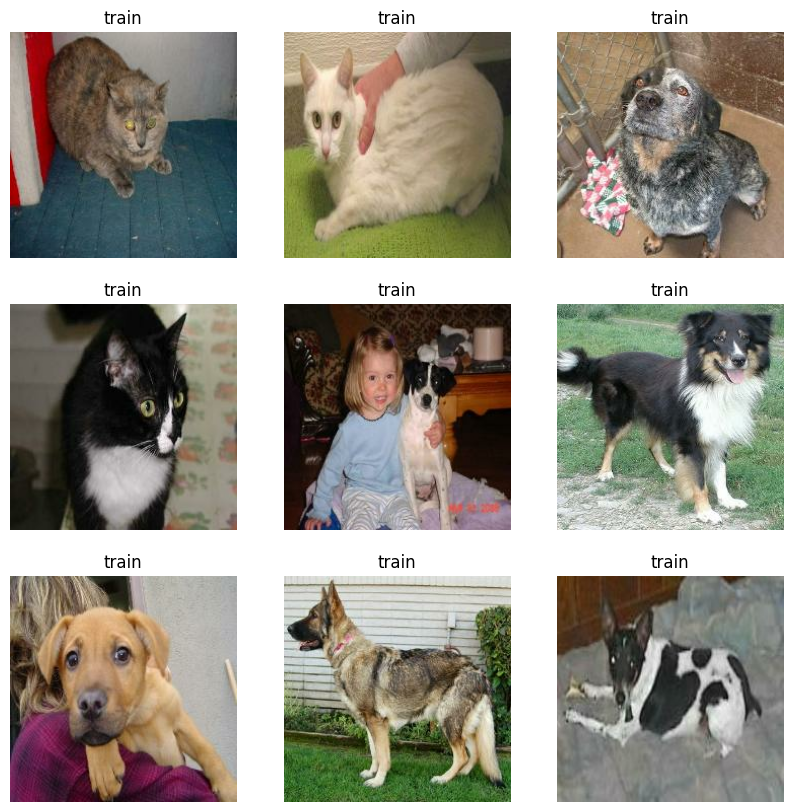

In [ ]:
# 일부 이미지를 시각화하여 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
# Prefetching 및 성능 최적화를 위한 설정
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## 5.2 기본CNN, MobileNetV2 모델링/평가/예측/시각화
### 기본 CNN 모델

In [ ]:
# 기본 CNN 모델 정의
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification: Cats vs Dogs
])

# 모델 컴파일
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 모델 요약 정보 출력
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history_cnn = cnn_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, batch_size=256, callbacks=[es, cp], verbose=1)

Epoch 1/10


In [ ]:
# 모델 평가
loss, accuracy = cnn_model.evaluate(validation_dataset)
print(f'image_dataset_from_directory활용 기본 CNN 모델 정확도: {accuracy}')

In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation_dataset.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = cnn_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()

### MobileNetV2 모델

In [ ]:
# MobileNetV2 모델 불러오기 (사전 훈련된 가중치 사용)
mobilenet_base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                   include_top=False,
                                                   weights='imagenet')

# 사전 학습된 층을 고정
mobilenet_base.trainable = False

# MobileNet을 이용한 모델 구축
mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
mobilenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history_mobilenetV2 = mobilenet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    batch_size=256,
    callbacks=[es, cp],
    verbose=1
)

In [ ]:
# 모델 평가
loss, accuracy = mobilenet_model.evaluate(validation_dataset)
print(f'image_dataset_from_directory활용 MobileNetV2 모델 정확도: {accuracy}')

In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation_dataset.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = mobilenet_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()

## 5.3 Tensorflow image data generator 활용 Data Augmentation

In [ ]:
DATASET_PATH

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,            # 0~1 범위로 정규화
    rotation_range=40,          # 이미지 회전 범위
    width_shift_range=0.2,      # 수평 이동 범위
    height_shift_range=0.2,     # 수직 이동 범위
    shear_range=0.2,            # 전단 변환 범위
    zoom_range=0.2,             # 확대/축소 범위
    horizontal_flip=True,       # 이미지 좌우 반전
    fill_mode='nearest'         # 빈 픽셀을 채우는 방식
)

# 검증 데이터는 증강을 하지 않고 정규화만 수행
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# 증강된 학습 데이터셋 로드
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,               # 이미지 경로
    target_size=(IMG_SIZE, IMG_SIZE),  # 이미지 크기 조정
    batch_size=BATCH_SIZE,      # 배치 크기
    class_mode='binary',        # 이진 분류 (Cats vs Dogs)
    subset='training',          # 훈련용 데이터셋
    seed=123                    # 시드 고정
)

# 검증 데이터셋 로드
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',        # 이진 분류
    subset='validation',        # 검증용 데이터셋
    seed=123
)


In [ ]:
# 증강된 이미지 시각화
import matplotlib.pyplot as plt

# 증강된 이미지들 중 일부를 시각화
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title("Augmented Image")
    plt.axis("off")
plt.show()

## 5.4 Augmented Dataset 기반 기본CNN 모델 성능개선 평가

In [ ]:
# 기본 CNN 모델 정의
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification: Cats vs Dogs
])

# 모델 컴파일
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
# 모델 요약 정보 출력
cnn_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history_cnn = cnn_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, batch_size=256, callbacks=[es, cp], verbose=1)

In [ ]:
# 모델 평가
loss, accuracy = cnn_model.evaluate(validation_dataset)
print(f'image_dataset_from_directory활용 기본 CNN 모델 정확도: {accuracy}')

In [ ]:
# 검증 데이터에서 일부 이미지 예측 및 시각화
import numpy as np

# 배치를 해제하여 개별 이미지와 레이블을 가져옵니다.
validation_unbatched = validation_dataset.unbatch()

# 검증 데이터에서 처음 10개 이미지 가져오기
sample_images = []
sample_labels = []
for image, label in validation_unbatched.take(10):
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

# 이미지 배열로 변환
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 예측 수행
predictions = cnn_model.predict(sample_images)

# 예측 결과 시각화
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    predicted_label = 'Dog' if predictions[i] > 0.5 else 'Cat'
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {predicted_label} / True: {true_label}')
    plt.axis('off')
    plt.show()